<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D4_DeepLearning1/W3D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day4, Tutorial 3
# Deep Learning: Building and Evaluating Convolutional Neural Network Models of the Visual System

By Jorge A. Menendez; reviewed by Carsen Stringer, Roozbeh Farhoodi, and Madineh Sarvestani


#Tutorial Objectives


In this tutorial, we'll be using deep learning to build a model of the visual system. Specifically, we will train a convolutional neural network to perform an orientation discrimination task -- a task we know that many mammalian visual systems are capable of solving. We will then try to dissect the structure of the internal representations used by the network to solve this task, and compare this structure to that observed in mouse primary visual cortex responses to similar oriented stimuli.

In this tutorial, we will learn how to:
* Build and train a convolutional neural network using PyTorch
* Visualize and analyze its internal representations
* Quantify the similarity of these representations to those recorded in mouse primary visual cortex, using Representational Similarity Analysis (RSA)

Video available at https://youtube.com/watch?v=RwptKHwhlPk


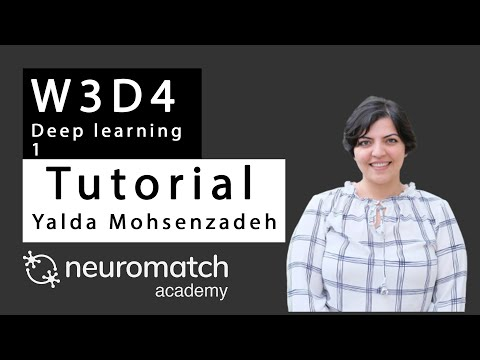

In [1]:
#@title Video: Deep convolutional network for orientation discrimination
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RwptKHwhlPk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


---
## Setup

**Don't forget to execute the hidden cells below!**

In [2]:
import os
import numpy as np
from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
#@title Download data

# Download data from OSF
data_filename = 'mouseV1.npy'
if data_filename in os.listdir():
  print('data already downloaded!')
else:
  print('downloading data...')
  !wget -O mouseV1.npy https://osf.io/6g4nz/download

data already downloaded!


In [4]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = (8, 6)

In [5]:
#@title Helper Functions

def load_data():
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontanous levels of activity and then z-scored over stimuli, so
  expect negative numbers.

  This function returns the relevant data (neural responses and
  stimulus orientations) as numpy arrays. Data includes only 
  responses to stimulus orientations between 0 and 180 degrees,
  and stimulus orientations are shifted to reflect relative angle
  from vertical, i.e. by subtracting pi/2

  Returns:
    resp (np.ndarray): n_stimuli x n_neurons matrix of neural responses,
      each row contains the responses of each neuron to a given stimulus,
      sorted by stimulus orientation
    stimuli: (np.ndarray): 1D array of length n_stimuli with orientation
      of each stimulus, angle from vertical in radians

  """
  
  data = np.load(data_filename, allow_pickle=True).item()
  stimuli = data['stimuli']

  # Extract responses only for stimuli between 0 and 180 degrees
  istim = (stimuli >= 0) * (stimuli <= np.pi)
  stimuli = stimuli[istim]
  resp = data['resp'][istim, :]

  # Sort by stimulus orientation
  isort = np.argsort(stimuli)
  stimuli = stimuli[isort]
  resp = resp[isort, :]

  # Subsample
  isub = np.arange(0, resp.shape[0], 2)
  stimuli = stimuli[isub]
  resp = resp[isub, :]
  
  # Transform stimulus orientations to be angle
  # from vertical
  stimuli -= np.pi / 2  # 0 means vertical, -ve means tilted left, +ve means tilted right

  return resp, stimuli


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating, angle from vertical in radians
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.
  
  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0
  
  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)
  
  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5
  
  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)


def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)
  
  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity


def plot_corr_matrix(rdm, ax=None):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity 
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing
  
  """
  if ax is None:
    ax = plt.gca()
  cax = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(cax, ax=ax, label='correlation coefficient')

---
## Orientation discrimination task

Run the next cell to see the stimuli we'll use in our orientation discrimination task. The task is to tell whether a given stimulus is tilted to the "right" or "left"; that is, whether its angle relative to the vertical is positive or negative, respectively.

stimulus size: 48 x 64


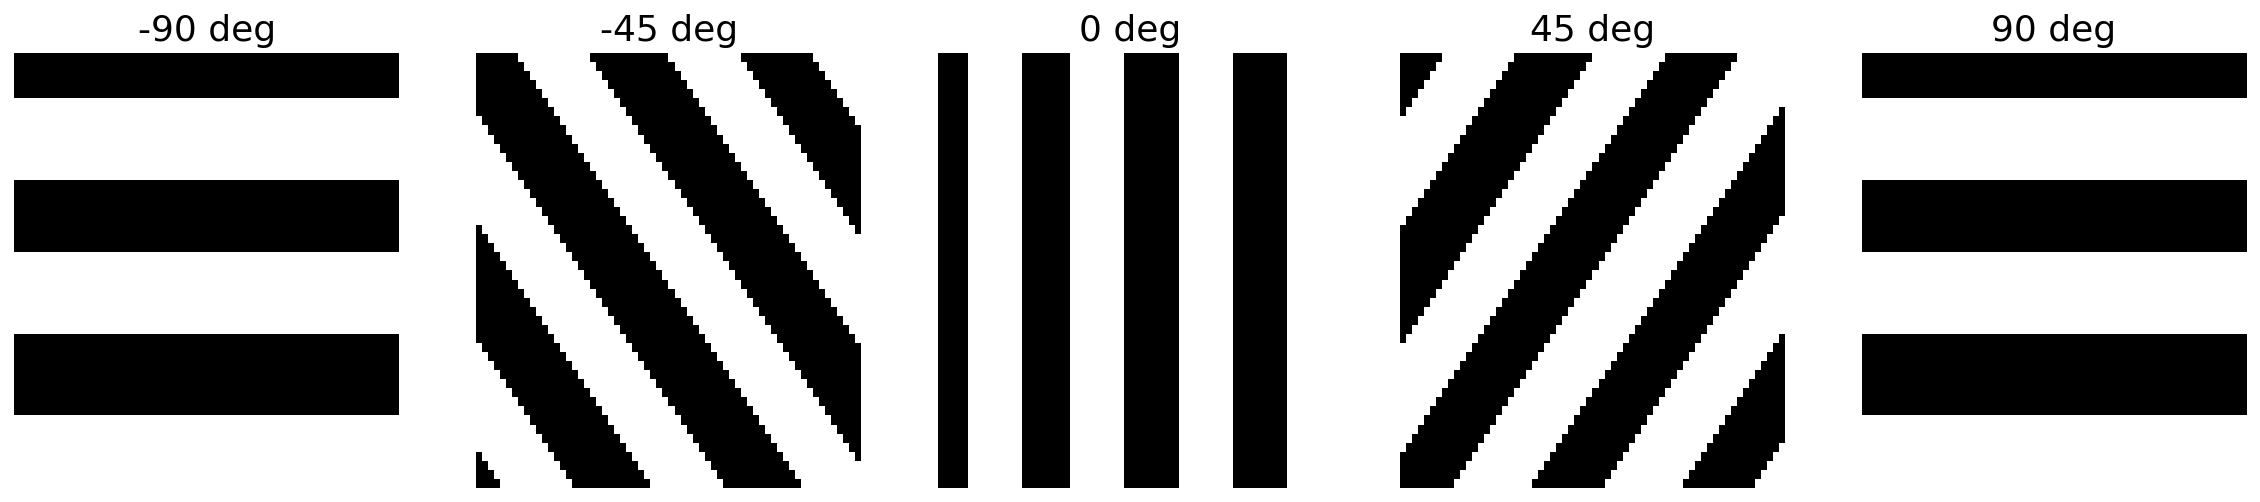

In [6]:
orientations = np.linspace(-np.pi / 2, np.pi / 2, 5)

fig, axs = plt.subplots(1, len(orientations), figsize=(len(orientations) * 4, 4))

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title('%.0f deg' % np.rad2deg(ori))
  show_stimulus(stimulus, axs[i])
plt.show()

---
## Convolutional neural networks

Our goal is to build a model that solves the orientation discrimination task. This model should take as input a stimulus image and output the probability of that stimulus being tilted right.

To do this, we will use a **convolutional neural network (CNN)**, which is a particular kind of neural network commonly used for image processing. CNN's are just like the networks we used to model single neuron responses in part 2 of this tutorial, except that they perform *two-dimensional* convolutions on the raw stimulus image (which is a 2D matrix of pixels), rather than *one-dimensional* convolutions on a categorical 1D vector representation of the stimulus.

We'll now walk through the different types of layers typically contained in a CNN.

#### **Fully connected layers**

In a fully connected layer, each unit computes a weighted sum over all the input units and applies a non-linear function to this weighted sum. You have used such layers many times already in parts 1 and 2. As you have already seen, these are implemented in PyTorch using the `nn.Linear` class.

  See the next cell for code for constructing a deep network with one fully connected layer that will classify an input image as being tilted left or right. Specifically, its output is the predicted probability of the input image being tilted right. To ensure that its output is a probability (i.e. a number between 0 and 1), we use a sigmoid activation function to squash the output into this range (implemented with `torch.sigmoid()`).

In [7]:
class FC(nn.Module):
  """Deep network with one fully connected layer

    Attributes:
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(h * w, 10)  # flattened input image --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.

    """
    x = x.view(-1, h * w)  # flatten each input image into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x


#### **Convolutional layers**

In a convolutional layer, each unit computes a weighted sum over a two-dimensional $K \times K$ patch of inputs (see appendix for a more detailed description). As we saw in part 2, the units are arranged in **channels** (see figure below), whereby units in the same channel compute the same weighted sum over different parts of the input, using the weights of that channel's **convolutional filter (or kernel)**. The output of a convolutional layer is thus a three-dimensional tensor of shape $C^{out} \times H \times W$, where $C^{out}$ is the number of channels (i.e. the number of convolutional filters/kernels), and $H$ and $W$ are the height and width of the input.

  <p align="center">
    <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/convnet.png?raw=true" width="350" />
  </p>

Such layers can be implemented in Python using the PyTorch class `nn.Conv2d`, which takes the same arguments as `nn.Conv1d` (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)).
  
See the next cell for code incorporating a convolutional layer with 16 convolutional filters of size 5 $\times$ 5 into our above fully connected network. Note that we have to flatten the multi-channel output in order to pass it on to the fully connected layer.

**Note:** as is also the case for the `nn.Conv1d` class, the inputs to `nn.Conv2d` layers must have a channel dimension in their first dimension. Thus, the input to a `nn.Conv2d` layer must be a 3D tensor of shape $C^{in} \times H \times W$ where $C^{in}$ is the number of input channels and $H, W$ their height and width, respectively. This means we'll have to make sure the stimulus images we feed into our network are 3D as well, like RGB images are. We'll do this by simply appending a singleton dimension, to reflect the fact that our grayscale images have a single color channel.

In [8]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer and one fully connected layer

    Attributes:
      conv (nn.Conv2d): convolutional layer
      dims (tuple of ints): dimensions of output from conv layer
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 16  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 5   # size of each convolutional kernel (should be odd number for the padding to work as expected)
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.dims = (C_out, h, w)  # dimensions of conv layer output, N.B. this requires that the above cell be run to define h and w!
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened conv output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = x.view(-1, np.prod(self.dims))  # flatten convolutional layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

#### **Max pooling layers**

In a max pooling layer, each unit computes the maximum over a small two-dimensional $K^{pool} \times K^{pool}$ patch of inputs. Given a multi-channel input of dimensions $C \times H \times W$, the output of a max pooling layer has dimensions $C \times H^{out} \times W^{out}$, where:
\begin{align}
  H^{out} &= \left\lfloor \frac{H}{K^{pool}} \right\rfloor\\
  W^{out} &= \left\lfloor \frac{W}{K^{pool}} \right\rfloor
\end{align}
where $\lfloor\cdot\rfloor$ denotes rounding down to the nearest integer below (i.e. floor division `//` in Python).

  Max pooling layers can be implemented with the PyTorch `nn.MaxPool2d` class, which takes as a single argument the size $K^{pool}$ of the pooling patch. See the next cell for an example, which builds upon the previous example by adding in a max pooling layer just after the convolutional layer. Note again that we need to calculate the dimensions of its output in order to set the dimensions of the subsequent fully connected layer.

In [9]:
class PoolConvFC(nn.Module):
  """Deep network with one convolutional layer and one fully connected layer

    Attributes:
      conv (nn.Conv2d): convolutional layer
      pool (nn.MaxPool2d): max pooling layer
      dims (tuple of ints): dimensions of output from pool layer
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 16  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 5   # size of each convolutional kernel
    Kpool = 2  # size of patches over which to pool
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool = nn.MaxPool2d(Kpool)
    self.dims = (C_out, h // Kpool, w // Kpool)  # dimensions of pool layer output, N.B. this requires that h and w be defined
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened pool output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = self.pool(x)  # output of pooling layer
    x = x.view(-1, np.prod(self.dims))  # flatten pooling layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

### Exercise 1

We're now ready to build a deep convolutional neural network model. The model we'll use here for orientation discrimination will have the following architecture:
1. an initial convolutional + pooling layer that convolves the input image with $C^{out}_1 = 16$ convolutional kernels of size $K_1 = 3$ and pools over patches of size $K^{pool}_1 = 2$,
2. a second convolutional + pooling layer with $C^{out}_2 = 4$ convolutional kernels of size $K_2 = 7$ and pools over patches of size $K^{pool}_2 = 2$,
3. a fully connected layer that reduces the representation to 10 dimensions,
4. an output layer that transforms this 10-dimensional representation to a single scalar between 0 and 1, denoting the probability of the input being a stimulus tilted right.

In the next cell, we've provided the code for building this model, with the second convolution + pooling layer missing. Your job is to fill this in. Remember that you'll have to compute the dimensionality of the outputs the second pooling layer (the tuple `dims2`) to appropriately set the input dimension of the subsequent `nn.Linear` layer.

In [10]:
class DeepCNN(nn.Module):
  """Convolutional neural network

    Attributes:
      conv1 (nn.Conv2d): first convolution layer
      pool1 (nn.MaxPool2d): first max pooling layer
      dims1 (tuple of ints): dimensions of output from pool1 layer
      conv2 (nn.Conv2d): second convolution layer
      pool2 (nn.MaxPool2d): second max pooling layer
      dims2 (tuple of ints): dimensions of output from pool2 layer
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()

    # Convolution + pooling layer 1
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 16  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 3  # size of each convolutional kernel
    Kpool = 2   # size of patches over which to pool
    self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool1 = nn.MaxPool2d(Kpool)
    self.dims1 = (C_out, h // Kpool, w // Kpool)  # dimensions of pool1 layer output

    # Convolution + pooling layer 2
    #####################################################################
    ## TO DO: add the second convolution + pooling layer
    # C_in = ...
    # C_out = 4
    # K = 7
    # Kpool = 2
    # self.conv2 = ...
    # self.pool2 = ...
    # self.dims2 = ...
    raise NotImplementedError("Student exercise: write code for initializing second convolution + pooling layer")
    #####################################################################
    
    # Fully connected layer
    self.fc = nn.Linear(np.prod(self.dims2), 10)  # flattened pool2 output --> 10D representation

    # Output layer
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv1(x))  # output of first convolutional layer
    x = self.pool1(x)  # output of first pooling layer
    #####################################################################
    ## TO DO for students: compute output of second convolution + pooling layer
    # x = ...  # output of second convolutional layer
    # x = ...  # output of second pooling layer
    raise NotImplementedError("Student exercise: write code for computing output of second convolution + pooling layer")
    #####################################################################
    x = x.view(-1, np.prod(self.dims2))  # flatten pooling layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

In [11]:
# to_remove solution
class DeepCNN(nn.Module):
  """Convolutional neural network

    Attributes:
      conv1 (nn.Conv2d): first convolution layer
      pool1 (nn.MaxPool2d): first max pooling layer
      dims1 (tuple of ints): dimensions of output from pool1 layer
      conv2 (nn.Conv2d): second convolution layer
      pool2 (nn.MaxPool2d): second max pooling layer
      dims2 (tuple of ints): dimensions of output from pool2 layer
      fc (nn.Linear): fully connected layer
      out (nn.Linear): output layer
    
    """
  
  def __init__(self):
    super().__init__()

    # Convolution + pooling layer 1
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 16  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 3   # size of each convolutional kernel
    Kpool = 2   # size of patches over which to pool
    self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool1 = nn.MaxPool2d(Kpool)
    self.dims1 = (C_out, h // Kpool, w // Kpool)  # dimensions of pool1 layer output

    # Convolution + pooling layer 2
    C_in = self.dims1[0]
    C_out = 4
    K = 7
    Kpool = 2
    self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)
    self.pool2 = nn.MaxPool2d(Kpool)
    self.dims2 = (C_out, self.dims1[1] // Kpool, self.dims1[2] // Kpool)
    
    # Fully connected layer
    self.fc = nn.Linear(np.prod(self.dims2), 10)  # flattened pool2 output --> 10D representation

    # Output layer
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
        x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
            each of p stimulus images.
    
    Returns:
        torch.Tensor: p x 1 tensor with network outputs for each input provided
            in x. Each output should be interpreted as the probability of the
            corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv1(x))  # output of first convolutional layer
    x = self.pool1(x)  # output of first pooling layer
    x = torch.relu(self.conv2(x))  # output of first convolutional layer
    x = self.pool2(x)  # output of first pooling layer
    x = x.view(-1, np.prod(self.dims2))  # flatten each pooling layer output into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

### Exercise 2

Run the convolutional neural network on a batch of 100 randomly oriented stimulus gratings, and compute what proportion of these stimuli were classified correctly. You'll have to
1. Complete the function `pcorrect()` that calculates the proportion of correctly classified stimuli from the network output and the true stimulus labels.
2. Initialize a deep CNN using the `deepCNN()` class from the previous exercise and use the `pcorrect()` function to evaluate its outputs for 100 randomly oriented stimulus gratings.

Recall that the output $p$ of the network is the estimated probability of the input stimulus being tilted to the right. The tilt predicted by the network is thus
\begin{equation}
  \begin{cases}
    \text{right} &\text{if } p > 0.5 \\
    \text{left} &\text{otherwise}
  \end{cases}
\end{equation}

In the next cell, we provide the function `sample_stimuli()` for randomly sampling stimuli and extracting their tilt.

**Hints:** 
* Use `.type(torch.float)` to cast boolean tensors (i.e. containing `True` and `False` values) into 1's and 0's corresponding to right/left classifications (see how `tilt` is computed below for the randomly sampled stimuli)
* You can use this to also represent correct/incorrect classifications with 1's and 0's, respectively. This will then allow you to calculate the proportion of correct classifications by simply taking the mean over these 1's and 0's.
* Make sure the output of `pcorrect()` is a scalar, rather than a `torch.Tensor`. This can be done by simply appending `.item()` at the end of any tensor. This method will invoke the `.detach()` method to detach it from any computational graph it is attached to and transform it into a scalar when possible.

In [12]:
def sample_stimuli(batch_size):
  """Randomly sample a batch of tilted grating stimuli

  Args:
    batch_size (int): number of stimuli to include in mini-batch
  
  Returns:
    torch.Tensor: batch_size x 48 x 64 tensor containing 48 x 64 pixel
      stimulus gratings
    torch.Tensor: contains tilt of each stimulus (1. for tilt right,
      0. for tilt left))

  """
  ori = (torch.rand(batch_size) - 0.5) * np.pi  # sample random orientations between -90 and +90 degrees
  stimuli = torch.stack([grating(a.item()) for a in ori])  # build orientated grating stimuli
  tilt = (ori > 0).type(torch.float)  # stimulus tilt: 1. if tilted right, 0. if tilted left
  return stimuli, tilt.unsqueeze(-1)  # make it a column vector to match output of CNN.forward()

In [13]:
def pcorrect(out, tilt):
  """Compute proportion of stimuli classified correctly from network output

  Args:
    out (torch.Tensor): output of network for each stimulus, i.e. the
      predicted probability of each stimulus being tilted right
    tilt (torch.Tensor): true tilt of each stimulus (1. for tilt right,
      0. for tilt left)
  
  Returns:
    float: proportion of stimuli classified correctly
  
  """
  ######################################################################
  ## TO DO for students: extract right/left labels for network outputs and calculate
  ## proportion of stimuli classified correctly
  # out_tilt = ...  # predicted tilt label: 1. for tilt right, 0. for tilt left (make sure to convert to float!)
  # return ...
  raise NotImplementedError("Student exercise: write code for computing output of second convolution + pooling layer")
  ######################################################################

# Sample 100 randomly oriented stimuli
stimuli, tilt = sample_stimuli(100)

#########################################################################
## TO DO for students: initialize CNN and use it to predict tilt right probability of 
## each stimulus
# net = ...
# out = ...
#########################################################################

# Compute proportion correct
# print('%.2f%% percent correct' % (100 * pcorrect(out, tilt)))  # UNCOMMENT

In [14]:
# to_remove solution
def pcorrect(out, tilt):
  """Compute proportion of stimuli classified correctly from network output

  Args:
    out (torch.Tensor): output of network for each stimulus, i.e. the
      predicted probability of each stimulus being tilted right
    tilt (torch.Tensor): true tilt of each stimulus (1. for tilt right,
      0. for tilt left)
  
  Returns:
    float: proportion of stimuli classified correctly
  
  """
  out_tilt = (out > 0.5).type(torch.float)  # predicted tilt label: 1. for tilt right, 0. for tilt left (make sure to convert to float!)
  return (tilt == out_tilt).type(torch.float).mean().item()

# Sample 100 randomly oriented stimuli
stimuli, tilt = sample_stimuli(100)

# Initialize CNN and use it to predict tilt right probability of each stimulus
net = DeepCNN()
out = net(stimuli)

# Compute proportion correct
print(f'{100 * pcorrect(out, tilt): .2f}% percent correct')

 48.00% percent correct


---
## Building a model of orientation discrimination with SGD

To turn this deep convolutional neural network into a model of orientation discrimination, we'll have to optimize its parameters to solve this task. As we did in part 1 of this tutorial, we'll use SGD to perform this optimization.

The first step is to pick a loss function. We first note that the orientation discrimination task is a **binary classification problem**, where the goal is to classify a given stimulus as being tilted either left or right. The loss function that reflects this objective is the **binary cross-entropy**. Let $\tilde{y}_i$ be the label of the $i$th stimulus in the mini-batch, indicating its true tilt:
\begin{equation}
  \tilde{y}_i =
  \begin{cases}
    1 &\text{if stimulus }i\text{ is tilted right} \\
    0 &\text{if stimulus }i\text{ is tilted left}
  \end{cases}
\end{equation}
Let $p_i$ be the predicted probability of that stimulus being tilted right assigned by our network (such that $1-p_i$ is the predicted probability of it being tilted left). The binary cross entropy of a mini-batch of $P$ stimuli is then given by
\begin{align}
  L &= -\sum_{i=1}^P \log \left( \text{predicted probability of stimulus } i \text{ being of class } \tilde{y}_i\right) \\
  &= -\sum_{i=1}^P
  \begin{cases}
    \log p_i &\text{if }\tilde{y}_i = 1 \\
    \log (1 - p_i) &\text{if }\tilde{y}_i = 0
  \end{cases}
  \\
  &= -\sum_{i=1}^P \tilde{y}_i \log p_i + (1 - \tilde{y}_i)\log(1 - p_i)
\end{align}
Note that this is just the negative log likelihood of the data in the mini-batch under the Bernoulli distribution implied by the probabilities assigned by the network. Thus, minimizing the loss is equivalent to maximizing the log likelihood. This resembles exactly the optimization performed in logistic regression, where we also optimize parameters by maximizing a Bernoulli log likelihood. The difference here is that the Bernoulli probabilities are the outputs of a deep convolutional neural network, rather than the outputs of a simple weighted linear sum like in logistic regression (cf. week 1: day 4).

The binary cross-entropy loss can be implemented in PyTorch using the `nn.BCELoss()` loss function (cf. [documentation](https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html)). In order to speed up training for the large number of parameters in this model, we'll use [momentum](https://distill.pub/2017/momentum/) in our SGD optimization. This can be easily incorporated into our PyTorch implementation by just setting the `momentum` argument of the `optim.SGD()` optimizer.

### Exercise 3

1. Complete the function `train()` implementing SGD on a binary cross-entropy loss. You'll have to fill in the code for sampling a mini-batch at each iteration and implementing the SGD updates. This is an opportunity to apply the techniques learned in part 1 of this tutorial.

2. Initialize a deep CNN model using `deepCNN()` class implemented in the earlier exercise and train it using the `train()` function.

**Hints:**
* Use the above defined function `sample_stimuli()` to sample mini-batches of stimuli.
* The cross-entropy loss can be evaluated using `loss_fn(out, tilt)`, where `out` is the network output, and `tilt` is the true stimulus tilt (1 for right, 0 for left). These can be tensors, including the outputs and tilts for all the stimuli in a batch.
* Use `.backward()` to compute gradients. Don't forget to clear the gradients first using `optimizer.zero_grad()`!!
* Use `optimizer.step()` to update the parameters at each iteration.

In [15]:
def train(net, hyperparams=dict(n_iter=200, learning_rate=1e-3, momentum=.99, batch_size=100)):
  """Run stochastic gradient descent for a given network on binary 
  cross-entropy loss
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD

  """

  # Set SGD hyperparameters
  n_iter = 200  # number of iterations of SGD
  learning_rate = 1e-3  # learning rate for SGD
  momentum = .99  # momentum parameter for SGD
  batch_size = 200  # number of data points in each mini-batch

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over iterations
  for i in range(n_iter):

    ###################################################################
    ## TO DO for students: sample mini-batch of batch_size oriented grating stimuli
    ## (Hint: use the above defined sample_stimuli() function!)
    # stimuli, tilt = ...
    raise NotImplementedError("Student exercise: write code for sampling mini-batch of oriented stimuli") 
    ###################################################################

    #################################################################
    ## TO DO for students: evaluate loss and update network weights
    # out = ...  # predicted probability of tilt right
    # loss = ...  # evaluate loss
    # ...  # clear gradients
    # ...  # compute gradients
    # ...  # update weights
    raise NotImplementedError("Student exercise: write code for computing network output, evaluating loss, and updating weights") 
    #################################################################
    
    # Keep track of loss at each iteration
    track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_iter / 10) == 0:
      print('iteration %i | loss: %.3f | percent correct: %.2f%%' % (i + 1, loss.item(), 100 * pcorrect(out, tilt)))
  
  # Plot loss
  plt.plot(track_loss)
  plt.xlabel('iterations of SGD')
  plt.ylabel('binary cross-entropy loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

######################################################################
## TO DO for students: initialize deep CNN and train it
# ...
######################################################################

iteration 20 | loss: 0.703 | percent correct: 50.00%


iteration 40 | loss: 0.726 | percent correct: 37.00%


iteration 60 | loss: 0.678 | percent correct: 60.00%


iteration 80 | loss: 0.647 | percent correct: 46.00%


iteration 100 | loss: 0.495 | percent correct: 95.00%


iteration 120 | loss: 0.156 | percent correct: 99.00%


iteration 140 | loss: 0.028 | percent correct: 98.00%


iteration 160 | loss: 0.043 | percent correct: 98.00%


iteration 180 | loss: 0.006 | percent correct: 100.00%


iteration 200 | loss: 0.000 | percent correct: 100.00%


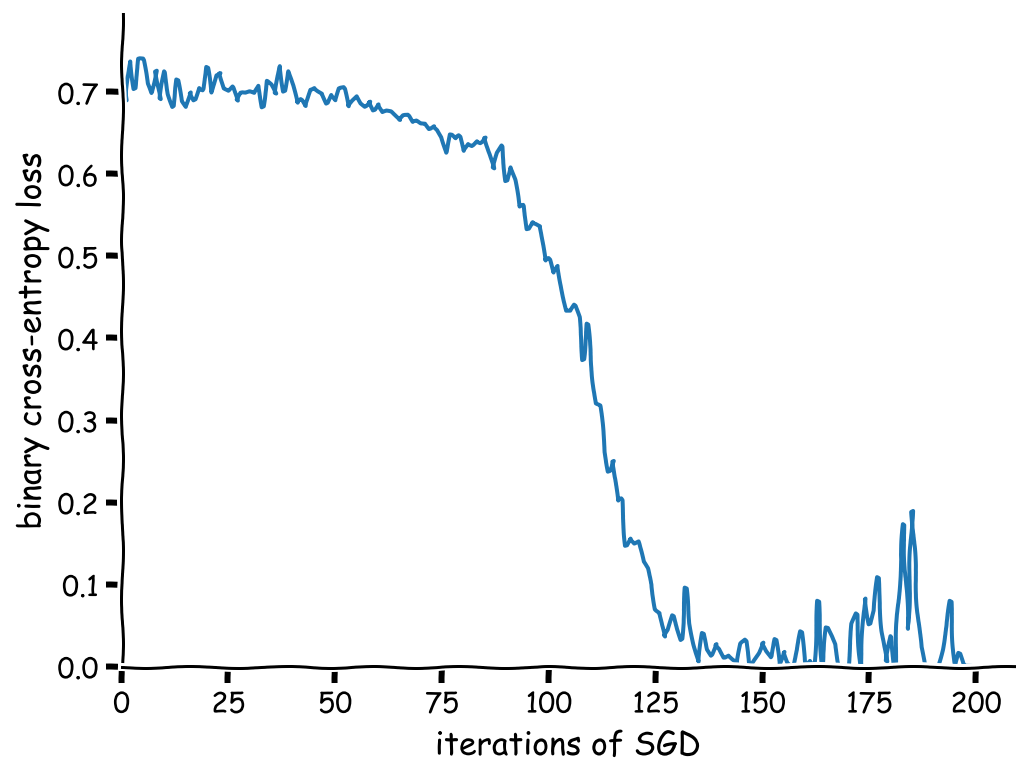

In [16]:
# to_remove solution
def train(net):
  """Run stochastic gradient descent on binary cross-entropy loss for a given
  deep network
  
  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
  """

  # Set SGD hyperparameters
  n_iter = 200  # number of iterations of SGD
  learning_rate = 1e-3  # learning rate for SGD
  momentum = .99  # momentum parameter for SGD
  batch_size = 100  # number of data points in each mini-batch

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over iterations
  for i in range(n_iter):

    # Sample minibatch of oriented grating stimuli
    stimuli, tilt = sample_stimuli(batch_size)

    # Evaluate loss and update network weights
    out = net(stimuli)  # predicted probability of tilt right
    loss = loss_fn(out, tilt)  # evaluate loss
    optimizer.zero_grad()  # clear gradients
    loss.backward()  # compute gradients
    optimizer.step()  # update weights
    
    # Keep track of loss at each iteration
    track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_iter / 10) == 0:
      print('iteration %i | loss: %.3f | percent correct: %.2f%%' % (i + 1, loss.item(), 100 * pcorrect(out, tilt)))
  
  # Plot loss
  plt.plot(track_loss)
  plt.xlabel('iterations of SGD')
  plt.ylabel('binary cross-entropy loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

# Initialize deep CNN and train it
net = DeepCNN()
with plt.xkcd():
  train(net)

Video available at https://youtube.com/watch?v=UEfOs9Ut3IM


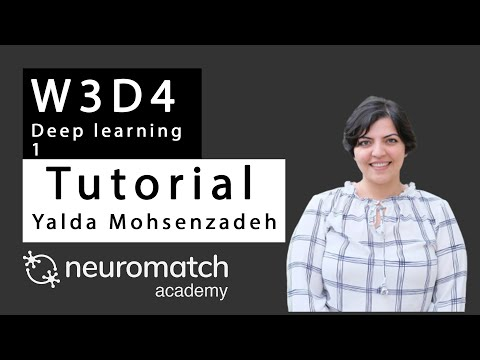

In [17]:
#@title Video: CNN's as models of visual system
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="UEfOs9Ut3IM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
## Visualize model and V1 representations of oriented stimuli

Let's now analyze the internal representations of our deep CNN model of orientation discrimination and qualitatively compare them to population responses in mouse primary visual cortex. In this section, we'll try to visualize them and get some intuition for their structure. In the next section, we'll try to quantitatively compare them.

In the next cell, we provide code for loading in some data from [this paper](https://www.biorxiv.org/content/10.1101/679324v2.abstract), which contains the responses of about ~20,000 neurons in mouse primary visual cortex to grating stimuli like those used to train our network (this is the same data used in part 1 of this tutorial). These data are stored in two variables:
* `resp_v1` is a matrix where each row contains the responses of all neurons to a single stimulus.
* `ori` is a vector with the orientations of each stimulus, in radians. As in the above convention, negative angles denote stimuli tilted to the left and positive angles denote stimuli tilted to the right.

Following this is code for extracting our deep CNN model's representations of these same stimuli (i.e. oriented gratings with the orientations in `ori`). We'll run these very same stimuli through our CNN model and use the `get_hidden_activity()` function to store its internal representations. The output of this function is a Python `dict`, which contains a matrix of population responses (just like `resp_v1`) for each layer of the network specified by the `layer_labels` argument. We'll focus on looking at the representations in
* the outputs of the first pooling layer, stored in the model as `'pool1'`
* the outputs of the second pooling layer, stored in the model as `'pool2'`
* the 10-dimensional outputs of the fully connected layer, stored in the model as `'fc'`

To visualize the representations in the data and in each of these model layers, we'll use two classic techniques from systems neuroscience:

1. **tuning curves**: plotting the response of single neurons (or units, in the case of the deep network) as a function of the stimulus orientation

2. **dimensionality reduction**: plotting full population responses to each stimulus in two dimensions via dimensionality reduction. We'll use the non-linear dimensionality reduction technique t-SNE for this.

In [18]:
help(get_hidden_activity)

Help on function get_hidden_activity in module __main__:

get_hidden_activity(net, stimuli, layer_labels)
    Retrieve internal representations of network
    
    Args:
      net (nn.Module): deep network
      stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
        compute and retrieve internal representations
      layer_labels (list): list of strings with labels of each layer for which
        to return its internal representations
    
    Returns:
      dict: internal representations at each layer of the network, in
        numpy arrays. The keys of this dict are the strings in layer_labels.



In [19]:
# Load mouse V1 data
resp_v1, ori = load_data()

# Extract model internal representations of each stimulus in the V1 data
stimuli = torch.stack([grating(a.item()) for a in ori])  # construct grating stimuli for each orientation presented to the mice in the V1 data
layer_labels = ['pool1', 'pool2', 'fc']
resp_model = get_hidden_activity(net, stimuli, layer_labels)

### Exercise 4

1. Complete the `plot_tuning_curve()` and `plot_dim_reduction()` functions below for plotting tuning curves and dimensionality-reduced population responses.

2. Use these functions to visualize the population responses recorded in the mouse V1 data and in the `pool1`, `pool2`, and `fc` layers of the model CNN. The code for this is provided. Your job is to interpret the resulting figures. Why do these representations look the way they do? Here are a few specific questions to think about:
  * How are the single neuron representations similar/different between the model and the data?
  * How are the population responses similar/different?
  * Can you explain the population-level responses from the single neuron responses, or vice-versa?
  * How do the representations in the different layers of the model differ, and how does this relate to the orientation discrimination task the model was optimized for?
  * Which layer of the neural network model most closely resembles the V1 data?

In [20]:
def plot_tuning_curve(resp, ori, ax=None):
  """Plot single neuron responses as a function of stimulus orientation

  Args:
    resp (numpy array): n_stimuli x n_neurons matrix with responses of each
      neuron whose tuning curve to plot. Can also be a 1D array of length 
      n_stimuli to plot tuning curve of a single neuron.
    ori (numpy array): 1D array of length stimuli with orientations of each
      stimulus, in radians
    ax (matplotlib axes): axes onto which to plot

  """
  
  if ax is None:
    ax = plt.gca()
  
  #########################################################
  ## TO DO for students: plot individual neuron tuning curves
  # ax.plot(..., ..., '.-')
  raise NotImplementedError("Student exercise: write code for plotting tuning curves") 
  #########################################################
  
  ax.set_xticks(np.linspace(-90, 90, 5))
  ax.set_xlabel('stimulus orientation')
  ax.set_ylabel('neuron response')

def plot_dim_reduction(resp, ori, ax=None):
  """Plot dimensionality-reduced population responses (using tSNE)

  Args:
    resp (numpy array): n_stimuli x n_neurons matrix with population responses
    ori (numpy array): 1D array of length stimuli with orientations of each
      stimulus, in radians
    ax (matplotlib axes): axes onto which to plot

  """
  if ax is None:
    ax = plt.gca()

  # First do PCA to reduce dimensionality to 200 dimensions so that tSNE is faster
  resp_lowd = PCA(n_components=min(200, resp.shape[1])).fit_transform(resp)

  # Then do tSNE to reduce dimensionality to 2 dimensions
  resp_lowd = TSNE(n_components=2).fit_transform(resp_lowd)

  ###############################################################
  ## TO DO for students: plot dimensionality-reduced population responses
  ## on 2D axes, with each point colored by stimulus orientation
  # scat = ax.scatter(..., ..., c=np.rad2deg(ori), cmap='twilight')
  raise NotImplementedError("Student exercise: write code for plotting dimensionality-reduced population responses")
  ###############################################################

  cbar = plt.colorbar(scat, ax=ax, label='stimulus orientation')
  ax.set_xlabel('dimension 1')
  ax.set_ylabel('dimension 2')
  ax.set_xticks([])
  ax.set_yticks([])

# Aggregate all responses into one dict
resp_dict = {}
resp_dict['V1 data'] = resp_v1
for k, v in resp_model.items():
  label = 'model\nlayer %s' % k
  resp_dict[label] = v

# Plot tuning curves and dimensionality-reduced responses next to each other

###############################################################
## TO DO for students: uncomment the lines below for visualization
#figsize = 4
#fig, axs = plt.subplots(2, len(resp_dict), figsize=(len(resp_dict) * figsize, 2 * figsize))

#for i, (label, resp) in enumerate(resp_dict.items()):

#  axs[0, i].set_title('%s responses' % label)

  ## Plot tuning curves of three random neurons
#  ineurons = np.random.choice(resp.shape[1], 3, replace=False)  # indices of three random neurons
#  plot_tuning_curve(resp[:, ineurons], ori, axs[0, i])

  ## Plot dimensionality-reduced population responses
#  plot_dim_reduction(resp, ori, axs[1, i])

#plt.tight_layout()
#plt.show()
###############################################################

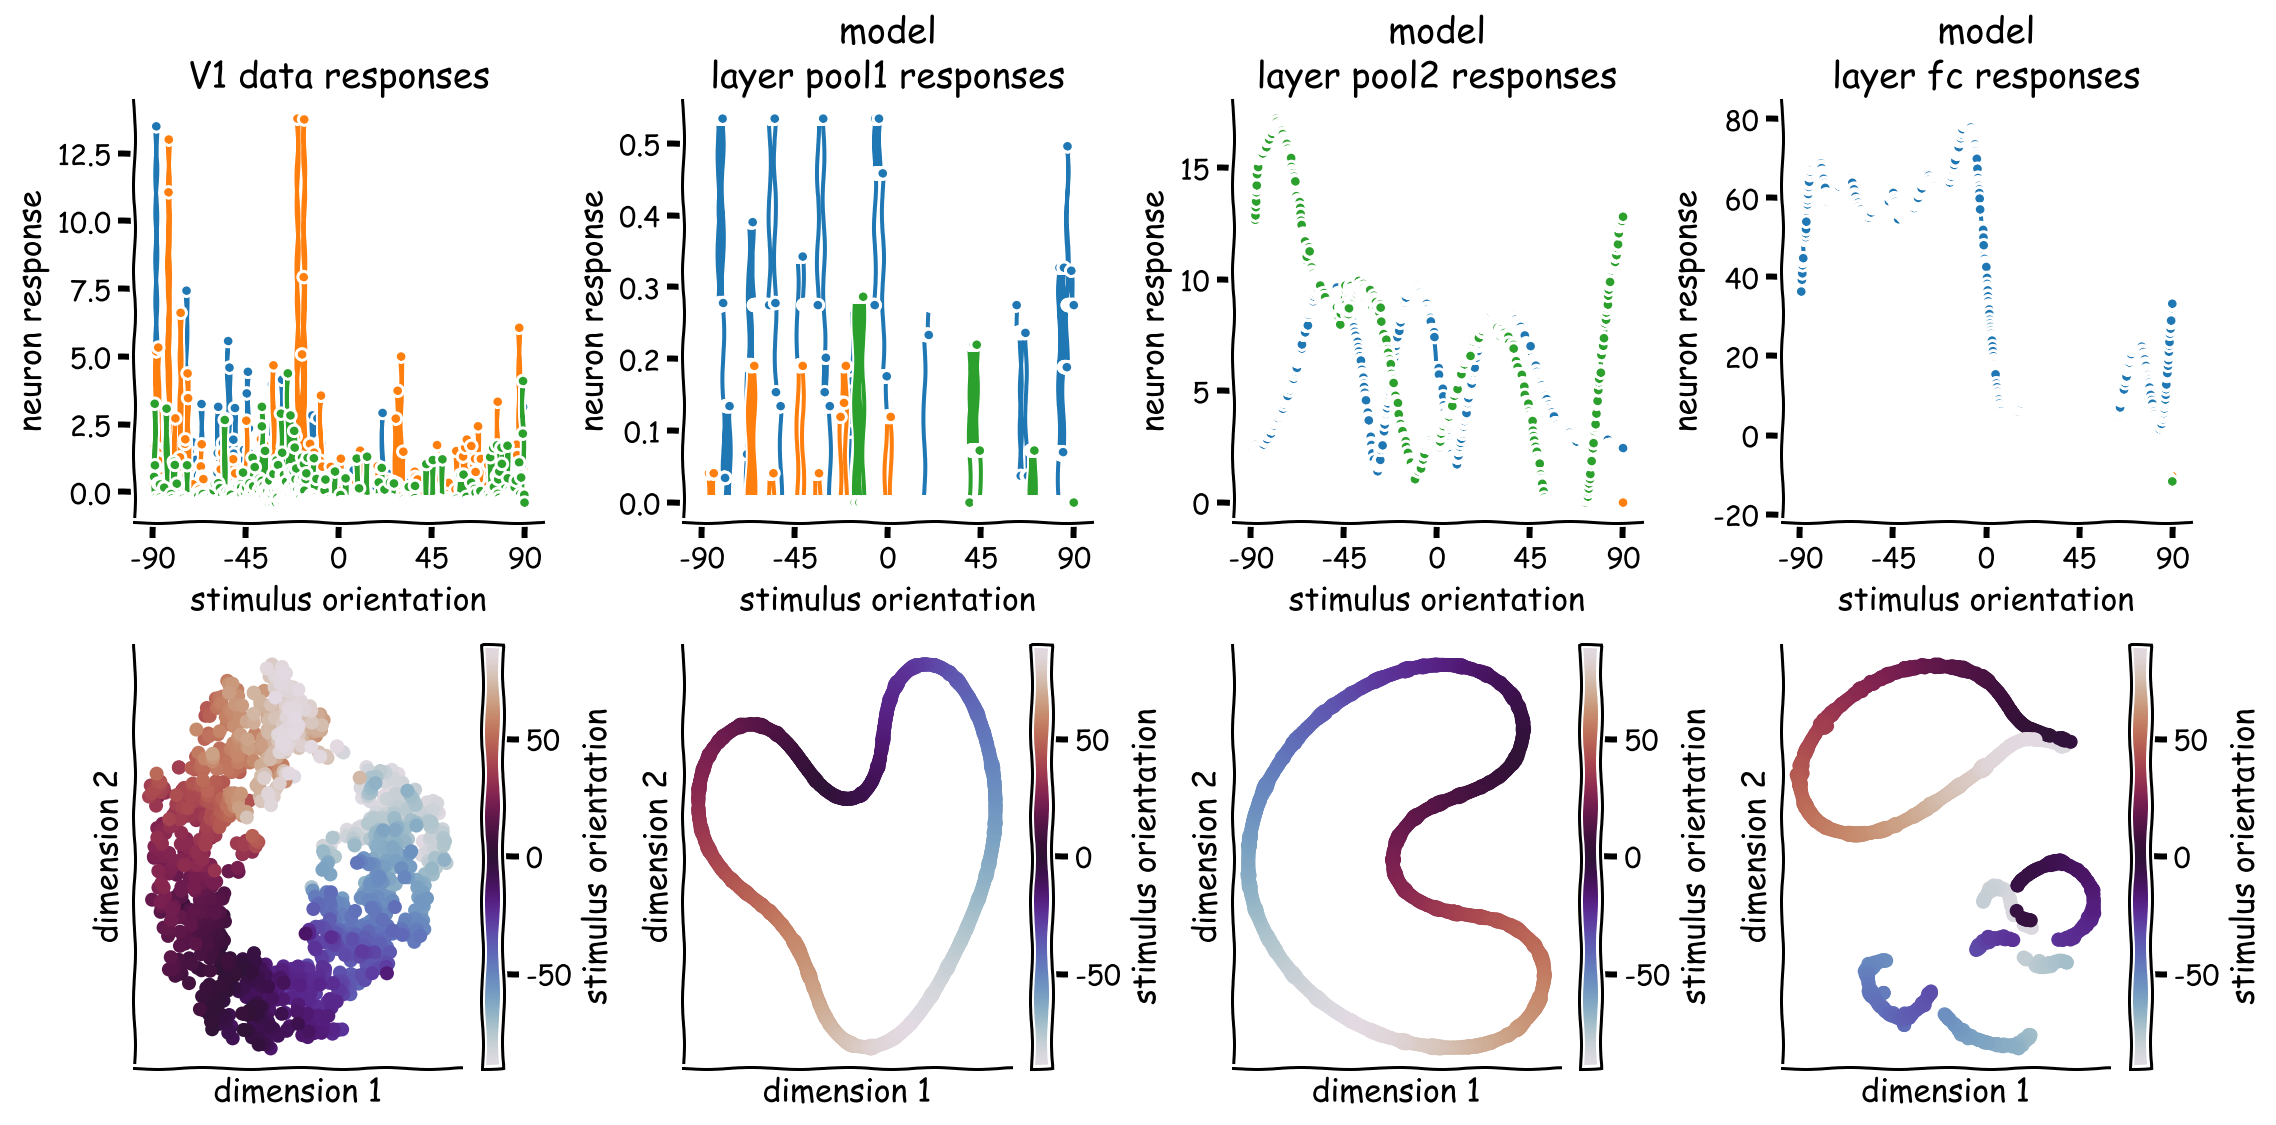

In [21]:
# to_remove
def plot_tuning_curve(resp, ori, ax=None):
  """Plot single neuron responses as a function of stimulus orientation

  Args:
    resp (numpy array): n_stimuli x n_neurons matrix with responses of each
      neuron whose tuning curve to plot. Can also be a 1D array of length 
      n_stimuli to plot tuning curve of a single neuron.
    ori (numpy array): 1D array of length stimuli with orientations of each
      stimulus, in radians
    ax (matplotlib axes): axes onto which to plot

  """
  if ax is None:
    ax = plt.gca()
  
  ax.plot(np.rad2deg(ori), resp, '.-')
  
  ax.set_xticks(np.linspace(-90, 90, 5))
  ax.set_xlabel('stimulus orientation')
  ax.set_ylabel('neuron response')

def plot_dim_reduction(resp, ori, ax=None):
  """Plot dimensionality-reduced population responses (using tSNE)

  Args:
    resp (numpy array): n_stimuli x n_neurons matrix with population responses
    ori (numpy array): 1D array of length stimuli with orientations of each
      stimulus, in radians
    ax (matplotlib axes): axes onto which to plot

  """
  if ax is None:
    ax = plt.gca()

  # First do PCA to reduce dimensionality to 200 dimensions so that tSNE is faster
  resp_lowd = PCA(n_components=min(200, resp.shape[1])).fit_transform(resp)

  # Then do tSNE to reduce dimensionality to 2 dimensions
  resp_lowd = TSNE(n_components=2).fit_transform(resp_lowd)

  # Plot dimensionality-reduced population responses
  # on 2D axes, with each point colored by stimulus orientation
  scat = ax.scatter(resp_lowd[:, 0], resp_lowd[:, 1], c=np.rad2deg(ori), cmap='twilight')
  
  cbar = plt.colorbar(scat, ax=ax, label='stimulus orientation')
  ax.set_xlabel('dimension 1')
  ax.set_ylabel('dimension 2')
  ax.set_xticks([])
  ax.set_yticks([])

# Aggregate all responses into one dict
resp_dict = {}
resp_dict['V1 data'] = resp_v1
for k, v in resp_model.items():
  label = 'model\nlayer %s' % k
  resp_dict[label] = v

# Plot tuning curves and dimensionality-reduced responses next to each other
with plt.xkcd():
  figsize = 4
  fig, axs = plt.subplots(2, len(resp_dict), figsize=(len(resp_dict) * figsize, 2 * figsize))

  for i, (label, resp) in enumerate(resp_dict.items()):

    axs[0, i].set_title('%s responses' % label)

    # Plot tuning curves of three random neurons
    ineurons = np.random.choice(resp.shape[1], 3, replace=False)  # indices of three random neurons
    plot_tuning_curve(resp[:, ineurons], ori, axs[0, i])

    # Plot dimensionality-reduced population responses
    plot_dim_reduction(resp, ori, axs[1, i])

  plt.tight_layout()
  plt.show()

---
## Representational Similarity Analysis (RSA)

We noticed above some similarities and differences between the population responses in mouse primary visual cortex and in different layers in our model. Let's now try to quantify this.

To do this, we'll use a technique called [**Representational Similarity Analysis**](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research). The idea is to look at the similarity structure between representations of different stimuli. We can say that a brain area and a model use a similar representational scheme if stimuli that are represented (dis)similarly in the brain are represented (dis)similarly in the model as well.

To quantify this, we begin by computing the **representational dissimilarity matrix (RDM)** for the mouse V1 data and each model layer. This matrix, which we'll call $\mathbf{M}$, is computed from the correlation coefficients between population responses to each stimulus. If $r^{(s)}_i$ is the response of the $i$th neuron to the $s$th stimulus, then
\begin{gather}
  M_{ss'} = 1 - \frac{\text{Cov}\left[ r_i^{(s)}, r_i^{(s')} \right]}{\sqrt{\text{Var}\left[ r_i^{(s)} \right] \text{Var}\left[ r_i^{(s')} \right]}} = 1 - \frac{\sum_{i=1}^N (r_i^{(s)} - \bar{r}^{(s)})(r_i^{(s')} - \bar{r}^{(s')}) }{\sqrt{\sum_{i=1}^N \left( r_i^{(s)} - \bar{r}^{(s)} \right)^2 \sum_{i=1}^N \left( r_i^{(s')} - \bar{r}^{(s')} \right)^2 }} \\
  \bar{r}^{(s)} = \frac{1}{N} \sum_{i=1}^N r_i^{(s)}
\end{gather}
This can be computed efficiently by using the $z$-scored responses
\begin{equation}
  z_i^{(s)} = \frac{r_i^{(s)} - \bar{r}^{(s)}}{\sqrt{\frac{1}{N}\sum_{i=1}^N \left( r_i^{(s)} - \bar{r}^{(s)} \right)^2}} \Rightarrow M_{ss'} = 1 - \frac{1}{N}\sum_{i=1}^N z_i^{(s)}z_i^{(s')}
\end{equation}
such that the full matrix can be computed through the matrix multiplication
\begin{gather}
  \mathbf{M} = 1 - \frac{1}{N} \mathbf{ZZ}^T \\
  \mathbf{Z} = 
  \begin{bmatrix}
    z_1^{(1)} & z_2^{(1)} & \ldots & z_N^{(1)} \\
    z_1^{(2)} & z_2^{(2)} & \ldots & z_N^{(2)} \\
    \vdots & \vdots & \ddots & \vdots \\
    z_1^{(S)} & z_2^{(S)} & \ldots & z_N^{(S)}
  \end{bmatrix}
\end{gather}


where $S$ is the total number of stimuli. Note that $\mathbf{Z}$ is an $S \times N$ matrix, and $\mathbf{M}$ is an $S \times S$ matrix.

### Exercise 5

Complete the function `RDM()` for computing the RDM for a given set of population responses to each stimulus. Use the above formula in terms of $z$-scored population responses. You can use the function `zscore()` to compute the matrix of $z$-scored responses.

The subsequent cell uses this function to plot the RDM of the population responses in the V1 data and in each layer of our model CNN.



In [22]:
help(zscore)

Help on function zscore in module scipy.stats.stats:

zscore(a, axis=0, ddof=0, nan_policy='propagate')
    Compute the z score.
    
    Compute the z score of each value in the sample, relative to the
    sample mean and standard deviation.
    
    Parameters
    ----------
    a : array_like
        An array like object containing the sample data.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Degrees of freedom correction in the calculation of the
        standard deviation. Default is 0.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan. 'propagate' returns nan,
        'raise' throws an error, 'omit' performs the calculations ignoring nan
        values. Default is 'propagate'.
    
    Returns
    -------
    zscore : array_like
        The z-scores, standardized by mean and standard deviation of
 

In [23]:
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp: S x N matrix with population responses to
      each stimulus in each row
  
  Returns:
    np.ndarray: S x S representational dissimilarity matrix
  """
  #########################################################
  ## TO DO for students: compute representational dissimilarity matrix
  # zresp = ...  # z-score responses to each stimulus
  # return ...
  raise NotImplementedError("Student exercise: write code for computing representational dissimilarity matrix")
  #########################################################

###############################################################
## TO DO for students: uncomment the lines below for visualization
#fig, axs = plt.subplots(1, len(resp_dict), figsize=(4 * len(resp_dict), 4))

## Compute RDM's for each set of responses and plot
#rdm_dict = {}
#for i, (label, resp) in enumerate(resp_dict.items()):
#  rdm_dict[label] = RDM(resp)
#  axs[i].set_title(label)
#  plot_corr_matrix(rdm_dict[label], axs[i])
###############################################################


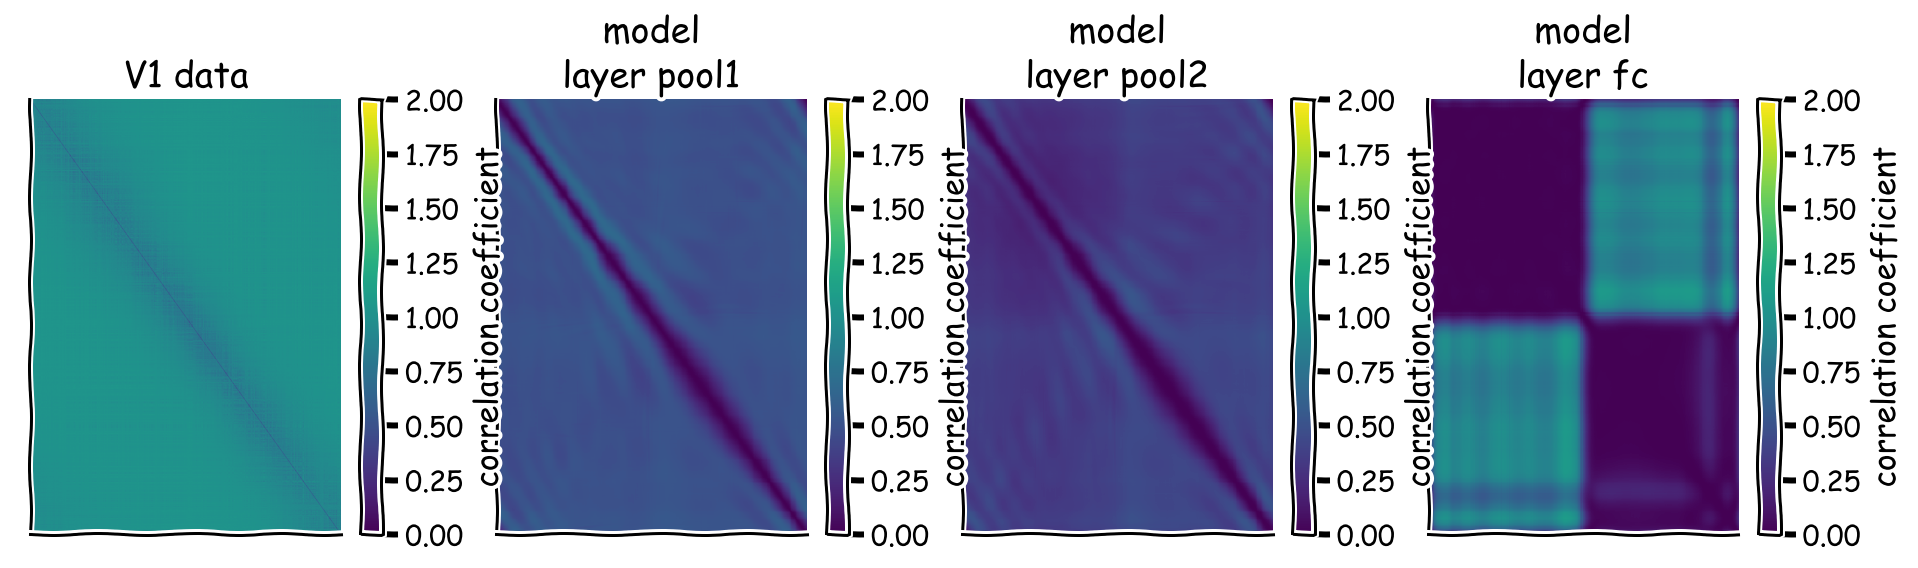

In [24]:
# to_remove
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp: S x N matrix with population responses to
      each stimulus in each row
  
  Returns:
    np.ndarray: S x S representational dissimilarity matrix
  """
  zresp = zscore(resp, axis=1)  # z-score responses to each stimulus
  return 1 - (zresp @ zresp.T) / zresp.shape[1]
with plt.xkcd():
  # Set up figure
  fig, axs = plt.subplots(1, len(resp_dict), figsize=(4 * len(resp_dict), 4))

  # Compute RDM's for each set of responses and plot
  rdm_dict = {}
  for i, (label, resp) in enumerate(resp_dict.items()):
    rdm_dict[label] = RDM(resp)
    axs[i].set_title(label)
    plot_corr_matrix(rdm_dict[label], axs[i])

### Exercise 6

To quantify how similar the representations are, we can simply correlate their dissimilarity matrices. For this, we'll again use the correlation coefficient. Note that dissimilarity matrices are symmetric ($M_{ss'} = M_{s's}$), so we should only use the off-diagonal terms on one side of the diagonal when computing this correlation to avoid overcounting. Moreover, we should leave out the diagonal terms, which are always equal to 0, so will always be perfectly correlated across any pair of RDM's.

Complete the function `correlate_rdms()` below that computes this correlation. Use the above $z$-score formula again for computing correlation coefficient. The code for extracting the off-diagonal terms is provided.

The subsequent cell uses this function to compute the correlation between the RDM's for each layer of our model CNN and that of the V1 data. According to this metric, which layer's representations most resemble those in the data? Does this agree with your intuitions from exercise #4?

In [25]:
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1
  
  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2
    
  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]
  
  #########################################################
  ## TO DO for students: compute correlation coefficient
  # return ...
  raise NotImplementedError("Student exercise: write code for computing correlation coefficient between RDMs")
  #########################################################

In [26]:
# to_remove solution
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1
  
  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2
    
  """
  
  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  # Compute correlation coefficient
  return zscore(rdm1_offdiag) @ zscore(rdm2_offdiag) / len(rdm2_offdiag)

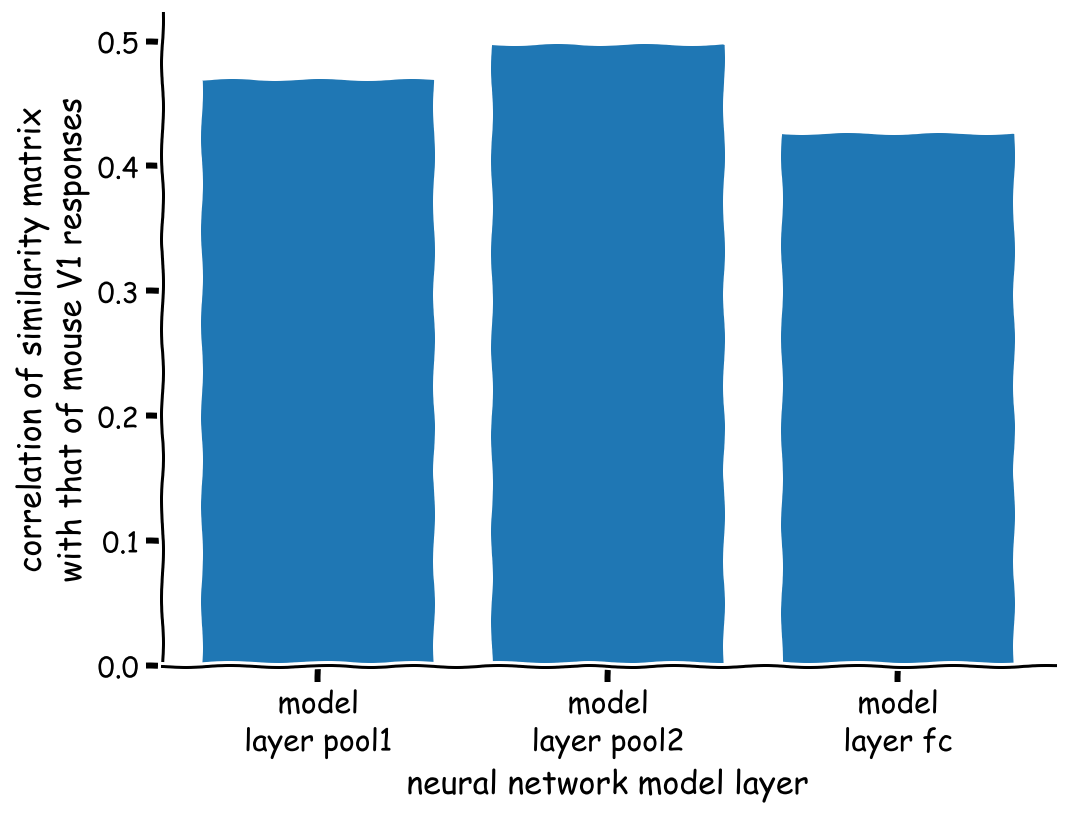

In [27]:
# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_v1 = rdm_model.pop('V1 data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_v1, rdm) for label, rdm in rdm_model.items()}

# Plot
with plt.xkcd():
  plt.bar(rdm_sim.keys(), rdm_sim.values())
  plt.tick_params(axis='x', labelsize=15)
  plt.xlabel('neural network model layer')
  plt.ylabel('correlation of similarity matrix\nwith that of mouse V1 responses')
  plt.show()

---
## Summary

In this notebook, we built and evaluated a neural network model of orientation discrimination. In doing so, we used the following techniques:
* two-dimensional convolutional layers
* max pooling layers layers
* representational similarity analysis (RSA)

Note that there are many other ways to build a model of orientation discrimination. The approach we took here, however, is special in that it uses distributed representations, allowing us to directly compare its representations with those in the brain (see appendix for a deeper discussion of why CNN's are useful for modeling visual tasks).

---
# Appendix

## Convolutional vs. fully connected layers

Convolutional layers are different from their fully connected counterparts in two ways (see figure below):
  * In a fully connected layer, each unit computes a weighted sum over all the input units. In a convolutional layer, on the other hand, each unit computes a weighted sum over only a small patch of the input, referred to as the unit's **receptive field**. When the input is an image, the receptive field can be thought of as a local patch of pixels.
  * In a fully connected layer, each unit uses its own independent set of weights to compute the weighted sum. In a convolutional layer, all the units (within the same channel) **share the same weights**. This set of shared weights is called the **convolutional filter or kernel**. The result of this computation is a convolution, where each unit has computed the same weighted sum over a different part of the input.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/weight-sharing.png?raw=true" width="700" />
</p>

## Why CNN's?

CNN models are particularly [well-suited](https://www.nature.com/articles/nn.4244) to modeling the visual system for a number of reasons:

1. **Distributed computation**: like any other neural network, CNN's use distributed representations to compute -- much like the brain seems to do. Such models, therefore, provide us with a vocabulary with which to talk and think about such distributed representations. Because we know the exact function the model is built to perform (e.g. orientation discrimination), we can analyze its internal representations with respect to this function and begin to interpret why the representations look the way they do. Most importantly, we can then use these insights to analyze the structure of neural representations observed in recorded population activity. We can qualitatively and quantitatively compare the representations we see in the model and in a given neural population to hopefully tease out the computations performed by that population.

2. **Hierarchical architecture**: like in any other deep learning architecture, each layer of a deep CNN comprises a non-linear transformation of the previous layer. Thus, there is a natural hierarchy whereby layers closer to the network output represent increasingly more abstract information about the input image. For example, in a network trained to do object recognition, the early layers might represent information about edges in the image, whereas later layers closer to the output might represent various object categories. This resembles the [hierarchical structure of the visual system](https://pubmed.ncbi.nlm.nih.gov/1822724/), where [lower-level areas](https://www.jneurosci.org/content/25/46/10577.short) (e.g. retina, V1) represent visual features of the sensory input and [higher-level areas](https://www.sciencedirect.com/science/article/pii/S089662731200092X) (e.g. V4, IT) represent properties of objects in the visual scene. We can then naturally use a single CNN to model multiple visual areas, using early CNN layers to model lower-level visual areas and late CNN layers to model higher-level visual areas.
  
  Relative to fully connected networks, CNN's, in fact, have further hierarchical structure built-in through the max pooling layers. Recall that each output of a convolution + pooling block is the result of processing a local patch of the inputs to that block. If we stack such blocks in a sequence, then the outputs of each block will be sensitive to increasingly larger regions of the initial raw input to the network: an output from the first block is sensitive to a single patch of these inputs, corresponding to its "receptive field"; an output from the second block is sensitive to a patch of outputs from the first block, which together are sensitive to a larger patch of raw inputs comprising the union of their receptive fields. Receptive fields thus get larger for deeper layers, further up the hierarchy. This resembles primate visual systems, where neurons in higher-level visual areas respond to stimuli in wider regions of the visual field than neurons in lower-level visual areas.

3. **Convolutional layers**: through the weight sharing constraint, the outputs of each channel of a convolutional layer process different parts of the input image in exactly the same way. This architectural constraint effectively builds into the network the assumption that objects in the world typically look the same regardless of where they are in space. This is useful for modeling the visual system for two (largely separate) reasons:
  * Firstly, this assumption is generally valid in mammalian visual systems, since mammals tend to view the same object from many perspectives. Two neurons at a similar hierarchy in the visual system with different receptive fields could thus end up receiving statistically similar synaptic inputs, so that the synaptic weights developed over time may end up being similar as well.
  * Secondly, this architecture significantly improves object recognition ability. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. Fully connected networks on their own can't achieve object recognition abilities anywhere close to human levels, making them bad models of human object recognition. Indeed, it is generally the case that [the better a neural network model is at object recognition, the closer the match between its representations and those observed in the brain](https://www.pnas.org/content/111/23/8619.short). That said, it is worth noting that our much simpler orientation discrimination task here can be solved by relatively simple networks.